# Task 2: Hyperelasticity



In [76]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib


### Data import

In [77]:
import numpy as np

import tensorflow as tf

def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    # F shape is (batch_size, 3, 3)
    batch_size = tf.shape(F)[0]
    
    # 计算右 Cauchy-Green 张量 C = F^T * F
    # Using einsum for batch matrix multiplication
    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = tf.linalg.trace(C)  # shape: (batch_size,)
    
    # For I2, compute trace(C@C) with batch operation
    C_square = tf.einsum('bij,bjk->bik', C, C)
    I2 = 0.5 * (I1**2 - tf.linalg.trace(C_square))  # shape: (batch_size,)
    
    # Compute determinant for each matrix in the batch
    J = tf.linalg.det(F)  # shape: (batch_size,)
    
    # 定义结构张量 Gti
    Gti = tf.constant([
        [4, 0, 0],
        [0, 0.5, 0],
        [0, 0, 0.5]
    ], dtype=tf.float32)
    
    # 扩展 Gti 到批量维度
    Gti = tf.tile(Gti[None, :, :], [batch_size, 1, 1])
    
    # 计算不变量 I4
    I4 = tf.linalg.trace(tf.einsum('bij,bjk->bik', C, Gti))  # shape: (batch_size,)
    
    # 计算 C 的余因子（Cofactor）
    # First compute inverse of C for each matrix in batch
    I3 = tf.linalg.det(C)

# 使用 I3 和 C 的逆计算 Cofactor 矩阵
    Cof_C = I3[:, None, None] * tf.linalg.inv(C)

    # 计算不变量 I5
    I5 = tf.linalg.trace(tf.einsum('bij,bjk->bik', Cof_C, Gti))  # shape: (batch_size,)
    
    return I1, J, I4, I5

In [78]:
data_biaxial = np.loadtxt('../../calibration/biaxial.txt')
data_pure_shear = np.loadtxt('../../calibration/pure_shear.txt')
data_uniaxial = np.loadtxt('../../calibration/uniaxial.txt')


def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    W = data[:, 18] 
    return F, P, W

# 分别处理三种加载路径的数据
F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_pure_shear, P_pure_shear, W_pure_shear = process_data(data_pure_shear)
F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)

In [79]:

I1_data_biaxial,J_data_biaxial,I4_data_biaxial,I5_data_biaxial = compute_invariants(F_biaxial) 
I1_data_pure_shear,J_data_pure_shear,I4_data_pure_shear,I5_data_pure_shear = compute_invariants(F_pure_shear)
I1_data_uniaxial,J_data_uniaxial,I4_data_uniaxial,I5_data_uniaxial = compute_invariants(F_uniaxial)

In [80]:
data_biaxial_test = np.loadtxt('../../test/biax_test.txt')
data_mixed_test = np.loadtxt('../../test/mixed_test.txt')

F_mixed_test, P_mixed_test, W_mixed_test = process_data(data_mixed_test)
F_biaxial_test, P_biaxial_test, W_biaxial_test = process_data(data_biaxial_test)
I1_data_biaxial_test,J_data_biaxial_test,I4_data_biaxial_test,I5_data_biaxial_test = compute_invariants(F_biaxial_test)
I1_data_mixed_test,J_data_mixed_test,I4_data_mixed_test,I5_data_mixed_test = compute_invariants(F_mixed_test)

In [81]:
import numpy as np

# 组合训练数据
I_train_biaxial = np.column_stack((I1_data_biaxial, J_data_biaxial, -J_data_biaxial, I4_data_biaxial, I5_data_biaxial))
I_train_pure_shear = np.column_stack((I1_data_pure_shear, J_data_pure_shear, -J_data_pure_shear, I4_data_pure_shear, I5_data_pure_shear))
I_train_uniaxial = np.column_stack((I1_data_uniaxial, J_data_uniaxial, -J_data_uniaxial, I4_data_uniaxial, I5_data_uniaxial))

# 将所有训练数据组合成一个整体训练集
I_train = np.concatenate([I_train_biaxial, I_train_pure_shear, I_train_uniaxial], axis=0)

# 组合测试数据
I_test_biaxial = np.column_stack((I1_data_biaxial_test, J_data_biaxial_test, -J_data_biaxial_test, I4_data_biaxial_test, I5_data_biaxial_test))
I_test_mixed = np.column_stack((I1_data_mixed_test, J_data_mixed_test, -J_data_mixed_test, I4_data_mixed_test, I5_data_mixed_test))

# 将所有测试数据组合成一个整体测试集
I_test = np.concatenate([I_test_mixed, I_test_biaxial], axis=0)


In [82]:
W_train = np.concatenate([W_biaxial, W_pure_shear, W_uniaxial], axis=0)

In [83]:
I_train_tensor = tf.convert_to_tensor(I_train, dtype=tf.float32)
W_train_tensor = tf.convert_to_tensor(W_train, dtype=tf.float32)
I_test_tensor = tf.convert_to_tensor(I_test, dtype=tf.float32)

### Load model

In [84]:
# %% Own modules
import models as lm
importlib.reload(lm)
model1 = lm.main()

model1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 5)]               0         
                                                                 
 private_c_to_w_2 (_C_to_W)  (None, 1)                 385       
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
21/21 [==============================] - 0s 5ms/step - loss: 346.8079
Epoch 2/2500
21/21 [==============================] - 0s 4ms/step - loss: 277.6747
Epoch 3/2500
21/21 [==============================] - 0s 4ms/step - loss: 251.8372
Epoch 4/2500
21/21 [==============================] - 0s 4ms/step - loss: 238.5575
Epoch 5/2500
21/21 [==============================] - 0s 3ms/step - loss: 228.3867
Epoch 6/2500
21/21 [==============================] - 0s 3ms/step - loss: 218.9521
Epoch 7/2500
21/21 [==============================] - 0s 3ms/step - loss: 210.7292
Epoch 8/2500
21/21 [==============================] - 0s 3ms/step - loss: 203.2998
Epoch 9/2500
21/21 [==============================] - 0s 3ms/step - loss: 197.0228
Epoch 10/2500
21/21 [==============================] - 0s 3ms/step - loss: 191.4087
Epoch 11/2500
21/21 [==============================] - 0s 3ms/step - loss: 186.8850
Epoch 12/2500
21/21 [==============================] - 0s 3ms/step - loss: 180.8199
E

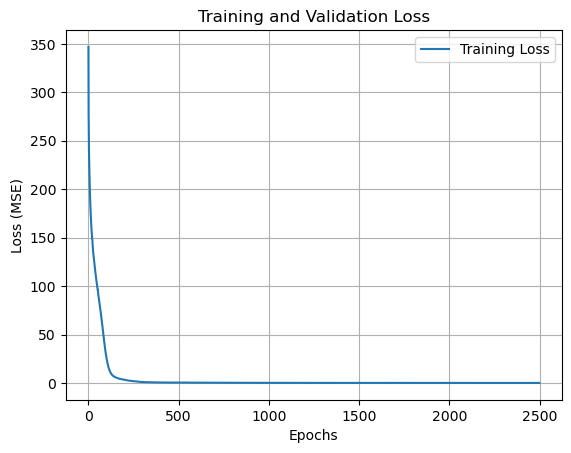

In [85]:

# 模型训练
history = model1.fit(I_train_tensor, W_train_tensor, epochs=2500)

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [86]:
def compute_stress_tensor(F,model):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(F)
        

        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)

    # 使用自动微分计算应力张量 P = dW/dF
    P = tape.gradient(W_pred, F)
    
    # 打印 P 以调试
    #print("P:", P)
    
    return P

In [87]:
P_biaxial_test_pred = compute_stress_tensor(F_biaxial_test,model1)
P_mixed_test_pred = compute_stress_tensor(F_mixed_test, model1)
P_biaxial_pred = compute_stress_tensor(F_biaxial, model1)
P_pure_shear_pred = compute_stress_tensor(F_pure_shear, model1)
P_uniaxial_pred = compute_stress_tensor(F_uniaxial, model1)

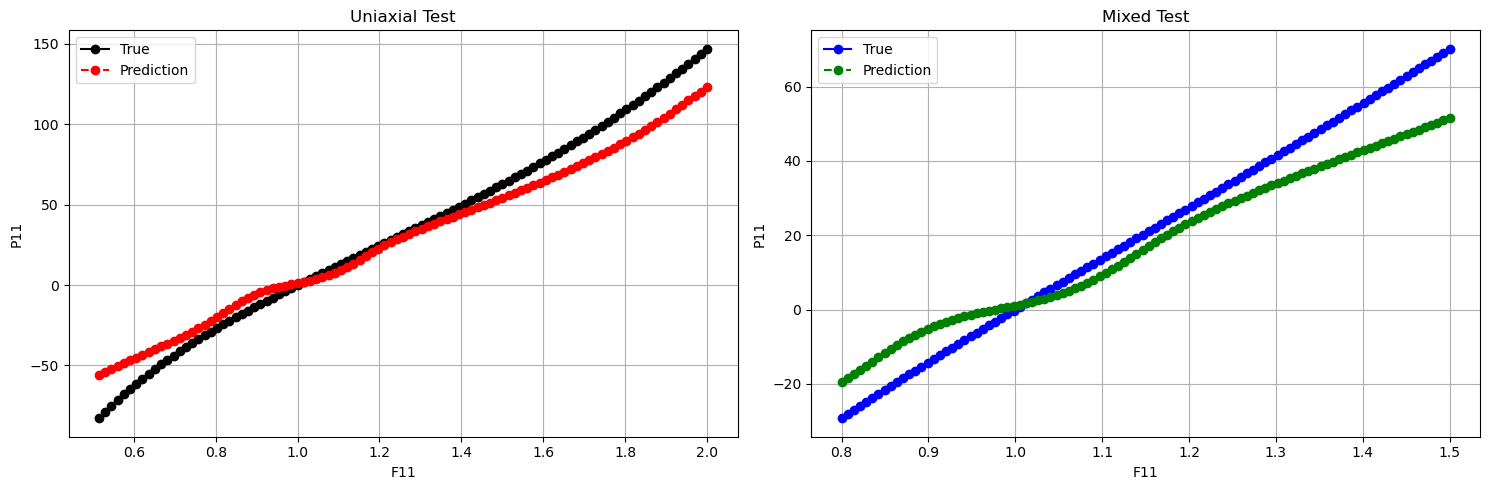

In [88]:

def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0, 0]


    # 创建一个包含三个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test")
    ax2.legend()
    ax2.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)

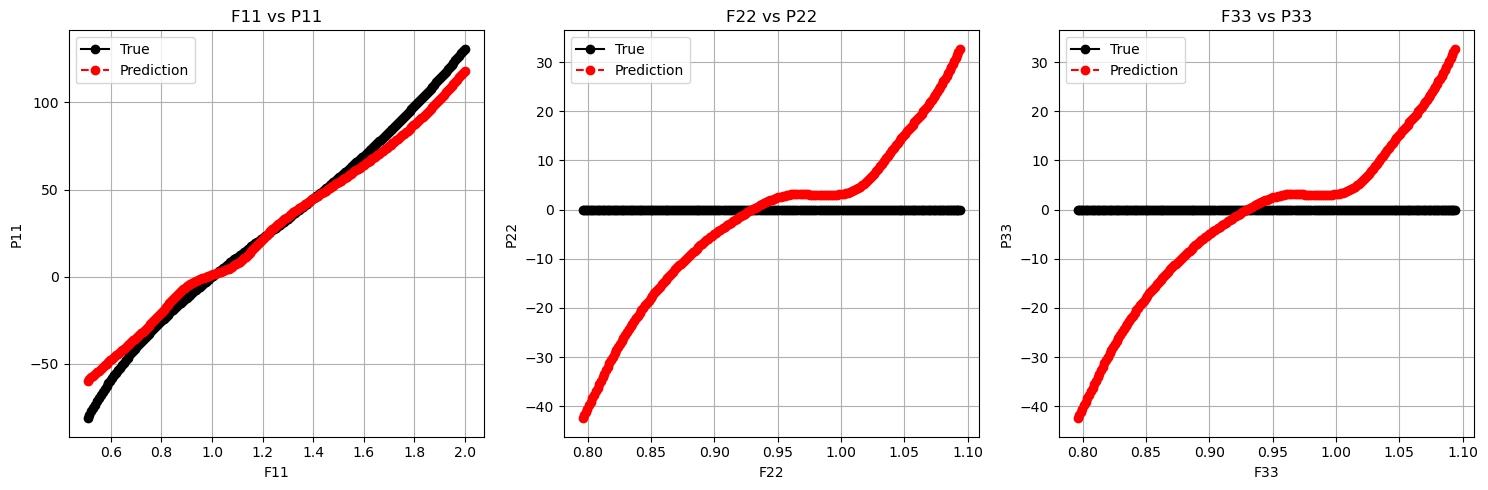

In [89]:
def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    # 提取 F 和 P 的不同分量
    F11 = F_uniaxial[:, 0, 0]  # 第一列
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] # 第三列

    P11 = P_uniaxial[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_uniaxial[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_uniaxial[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_uniaxial_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_uniaxial_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_uniaxial_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)


### Calibrate the model using both

In [90]:
model2 = model1
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# 训练步骤
def train_step(F, P_true, model):
    with tf.GradientTape(persistent=True) as tape:  # 使用 persistent=True
        tape.watch(F)
        
        # 计算输入 F 的不变量，并通过模型进行预测
        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)
        
        # 计算应力张量 P = dW/dF
        P_pred = tape.gradient(W_pred, F)
        
        # 计算 MSE 损失 
        loss_P = tf.reduce_mean(tf.square(P_pred - P_true))  # 计算 MSE
        loss = loss_P
    # 计算梯度并优化
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [91]:
F_train = np.concatenate([F_biaxial, F_pure_shear, F_uniaxial], axis=0)
F_train_tensor = tf.convert_to_tensor(F_train, dtype=tf.float32)
P_train = np.concatenate([P_biaxial, P_pure_shear, P_uniaxial], axis=0)
P_train_tensor = tf.convert_to_tensor(P_train, dtype=tf.float32)

In [92]:
for epoch in range(2000):
    # 假设 F_train 和 P_true_train 是训练集的变形梯度和真实应力张量
    loss = train_step(F_train_tensor, P_train_tensor, model2)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")

Epoch 1, Loss: 211.6353302001953
Epoch 2, Loss: 208.5332489013672
Epoch 3, Loss: 205.56292724609375
Epoch 4, Loss: 202.73867797851562
Epoch 5, Loss: 200.01071166992188
Epoch 6, Loss: 197.3753662109375
Epoch 7, Loss: 194.8288116455078
Epoch 8, Loss: 192.36741638183594
Epoch 9, Loss: 189.98849487304688
Epoch 10, Loss: 187.69004821777344
Epoch 11, Loss: 185.47067260742188
Epoch 12, Loss: 183.32940673828125
Epoch 13, Loss: 181.26536560058594
Epoch 14, Loss: 179.27764892578125
Epoch 15, Loss: 177.36529541015625
Epoch 16, Loss: 175.5272979736328
Epoch 17, Loss: 173.76248168945312
Epoch 18, Loss: 172.0695037841797
Epoch 19, Loss: 170.44696044921875
Epoch 20, Loss: 168.89321899414062
Epoch 21, Loss: 167.4065399169922
Epoch 22, Loss: 165.9849853515625
Epoch 23, Loss: 164.62649536132812
Epoch 24, Loss: 163.32879638671875
Epoch 25, Loss: 162.08946228027344
Epoch 26, Loss: 160.90597534179688
Epoch 27, Loss: 159.77561950683594
Epoch 28, Loss: 158.6956024169922
Epoch 29, Loss: 157.66307067871094
Epo

In [93]:
P_biaxial_test_pred = compute_stress_tensor(F_biaxial_test,model2)
P_mixed_test_pred = compute_stress_tensor(F_mixed_test, model2)
P_biaxial_pred = compute_stress_tensor(F_biaxial, model2)
P_pure_shear_pred = compute_stress_tensor(F_pure_shear, model2)
P_uniaxial_pred = compute_stress_tensor(F_uniaxial, model2)

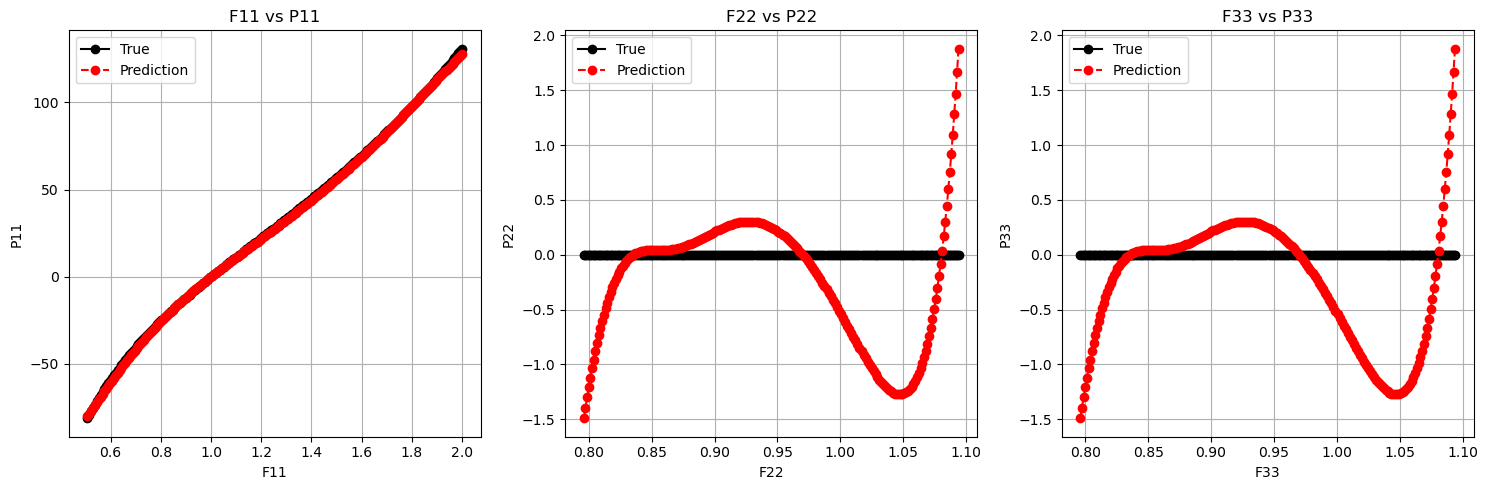

In [94]:
def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    # 提取 F 和 P 的不同分量
    F11 = F_uniaxial[:, 0, 0]  # 第一列
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] # 第三列

    P11 = P_uniaxial[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_uniaxial[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_uniaxial[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_uniaxial_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_uniaxial_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_uniaxial_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)


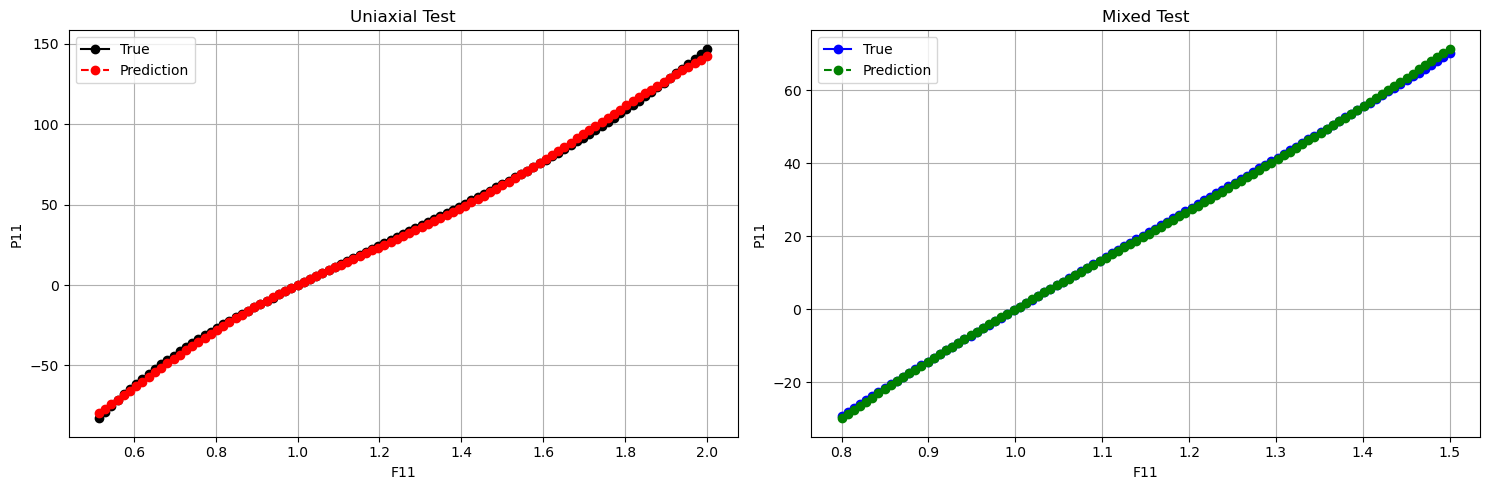

In [95]:
import matplotlib.pyplot as plt


def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0, 0]


    # 创建一个包含三个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test")
    ax2.legend()
    ax2.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)


### Loris

In [103]:
from tensorflow.keras import layers
from tensorflow.keras import constraints
def calc_invariants(F):
    G_ti     = tf.constant([[4,0,0], [0,0.5,0], [0,0,0.5]])
    C        = tf.matmul(tf.transpose(F, perm=[0, 2, 1]), F)
    #C_inv    = tf.linalg.inv(C)
    C_inv = tf.linalg.inv(C + tf.eye(3) * 1e-6)  # Kleine Diagonalstörung hinzufügen
    I_1      = tf.linalg.trace(C)
    J        = tf.linalg.det(F)
    I_3      = tf.linalg.det(C)  #(199,)
    I_3_exp  = tf.expand_dims(tf.expand_dims(I_3, axis=-1), axis=-1)
    cof_C    = I_3_exp * C_inv
    I_4      = tf.linalg.trace(tf.matmul(C, G_ti))
    I_5      = tf.linalg.trace(tf.matmul(cof_C, G_ti))
    W        = 8 * I_1 + 10 * J**2 - 56 * tf.math.log(J) + 0.2 * (I_4**2 + I_5**2) - 44
    return tf.stack([I_1, J, -J, I_4, I_5], axis=1) # shape(648,5)


class PANN(layers.Layer):
    def __init__(self):
        super(PANN, self).__init__()
        self.ls  = [layers.Dense(16, activation='softplus')]
        self.ls += [layers.Dense(16, activation='softplus', kernel_constraint=constraints.NonNeg())]
        self.ls += [layers.Dense(1,  activation='softplus', kernel_constraint=constraints.NonNeg())]

    def call(self, invariants):
        for l in self.ls:
            invariants = l(invariants)
        # Output von letzter Schicht ist W
        W = invariants
        return W


# Initialisierung des Modells und dem Optimierer
inputs    = tf.keras.Input(shape=(5,))
output    = PANN()(inputs)
model     = tf.keras.Model(inputs=inputs, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)


# Benutzerdefinierte Trainingsschleife mit GradientTape

@tf.function # optimiert TensorFlow-Funktionen, indem sie in einen Berechnungsgraphen kovertiert werden
def train_step(F, W_true, P_true, sample_weight=None, train_on="both"):
    F = tf.cast(F, tf.float32)
    W_true = tf.cast(W_true, tf.float32)
    P_true = tf.cast(P_true, tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(F)                                           # F wird beobachtet, um später P zu berechenen (Link zw. F und W aufbauen)
        I = calc_invariants(F)                                  # Berechnung der Invarianten auf Basis des Deformationstensors                                                   
        W_pred = model(I)                                       # Modellvorhersage für das hyperelastische Potential W
        P_pred = tape.gradient(W_pred, F)                       # Gradient von W_pred bzgl. F => themodynamische Konsistenz

        
        # Umformung von W_true, um sicherzustellen, dass es die richtige Form hat
        W_true = tf.reshape(W_true, [-1, 1])

        # Falls sample_weight None ist, setze es auf Einsen
        if sample_weight is None:
            sample_weight = tf.ones_like(W_true, dtype=tf.float32)
        else:
            sample_weight = tf.reshape(sample_weight, [-1, 1])
            sample_weight = tf.broadcast_to(sample_weight, tf.shape(W_true))

        # sample_weight für P_pred anpassen
        sample_weight_P = tf.reshape(sample_weight, [-1, 1, 1])  # Auf [batch_size, 1, 1] erweitern
        sample_weight_P = tf.broadcast_to(sample_weight_P, tf.shape(P_pred))  # Auf [batch_size, 3, 3] erweitern

        # Verlustberechnung
        loss_W = tf.reduce_mean(tf.square(W_pred - W_true) * sample_weight)
        loss_P = tf.reduce_mean(tf.square(P_pred - P_true) * sample_weight_P)


        # Zuweisung des Gesamtfehlers in abhängigkeit von "train_on"
        if train_on == "W":
            total_loss = loss_W
        elif train_on =="P":
            total_loss = loss_P
        elif train_on =="both":
            total_loss = loss_W + loss_P

        # Optimierung der Kostenfunktion
        grad_loss = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad_loss, model.trainable_variables))
        del tape
        return total_loss, W_pred, P_pred

# haupttrainingsschleife mit Batch-Verarbeitung
def train_model(F_train, W_train, P_train, epochs, batch_size, sample_weight=None):

    # Anzahl der "batch-dimesion" entspricht der Anzahl der Messpunkte
    n_samples = F_train.shape[0]

    # Anzahl Batches (Ganzzahlig)
    n_batches = n_samples // batch_size

    history = []

    # Doppelte for schleife, um durch die trainingsdatan zu slicen mit batch_size und das für jede Epoch
    for epoch in range(epochs):
        # Initialiserung des Fehlers auf null
        epoch_loss = 0

        for batch in range(n_batches):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size

            batch_F = F_train[start_idx:end_idx]
            batch_W = W_train[start_idx:end_idx]
            batch_P = P_train[start_idx:end_idx]

            # Prepare batch-level sample_weight
            if sample_weight is not None:
                batch_sample_weight = sample_weight[start_idx:end_idx]
                batch_sample_weight = tf.convert_to_tensor(batch_sample_weight, dtype=tf.float32)
            else:
                batch_sample_weight = tf.ones_like(batch_W, dtype=tf.float32)

            loss, _, _ = train_step(batch_F, batch_W, batch_P, batch_sample_weight)
            epoch_loss += loss

        epoch_loss = epoch_loss / n_batches
        history.append(epoch_loss)

        # Ausgabe des Fehlers z.B. alle 10 Epochen
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {epoch_loss:4f}")
    
    return history


In [104]:
epochs = 2000      # 训练轮数
batch_size = 32    # 批次大小
sample_weight = None  # 可选的样本权重

In [105]:
# 创建并训练模型
history = train_model(F_train_tensor, W_train_tensor, P_train_tensor, 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     sample_weight=sample_weight)


Epoch 0: Loss = 840.632629
Epoch 10: Loss = 519.879456
Epoch 20: Loss = 462.539948
Epoch 30: Loss = 406.783661
Epoch 40: Loss = 351.221832
Epoch 50: Loss = 296.279175
Epoch 60: Loss = 243.641449
Epoch 70: Loss = 195.295547
Epoch 80: Loss = 152.906052
Epoch 90: Loss = 117.419411
Epoch 100: Loss = 89.094376
Epoch 110: Loss = 67.664558
Epoch 120: Loss = 52.443836
Epoch 130: Loss = 42.172630
Epoch 140: Loss = 35.312073
Epoch 150: Loss = 30.611933
Epoch 160: Loss = 27.209187
Epoch 170: Loss = 24.591444
Epoch 180: Loss = 22.469738
Epoch 190: Loss = 20.681604
Epoch 200: Loss = 19.131660
Epoch 210: Loss = 17.760174
Epoch 220: Loss = 16.527822
Epoch 230: Loss = 15.408270
Epoch 240: Loss = 14.383649
Epoch 250: Loss = 13.442332
Epoch 260: Loss = 12.576284
Epoch 270: Loss = 11.779696
Epoch 280: Loss = 11.047894
Epoch 290: Loss = 10.376613
Epoch 300: Loss = 9.761419
Epoch 310: Loss = 9.197744
Epoch 320: Loss = 8.681063
Epoch 330: Loss = 8.206861
Epoch 340: Loss = 7.770791
Epoch 350: Loss = 7.368880

In [106]:
import tensorflow as tf
import numpy as np

def predict(model, F_new):
    """
    使用训练好的模型进行预测
    
    参数:
    model: 训练好的PANN模型
    F_new: 新的变形梯度数据，形状为(样本数, 3, 3)
    
    返回:
    W_pred: 预测的应变能密度
    P_pred: 预测的应力张量
    """
    # 确保输入数据类型为float32
    F_new = tf.cast(F_new, tf.float32)
    
    # 使用GradientTape来计算梯度（应力张量）
    with tf.GradientTape() as tape:
        tape.watch(F_new)
        # 计算不变量
        invariants = calc_invariants(F_new)
        # 预测应变能密度
        W_pred = model(invariants)
        # 计算应力张量（W对F的梯度）
        P_pred = tape.gradient(W_pred, F_new)
    
    return W_pred, P_pred


W_biaxial_test_pred, P_biaxial_test_pred = predict(model, F_biaxial_test)
W_mixed_test_pred, P_mixed_test_pred = predict(model, F_mixed_test)



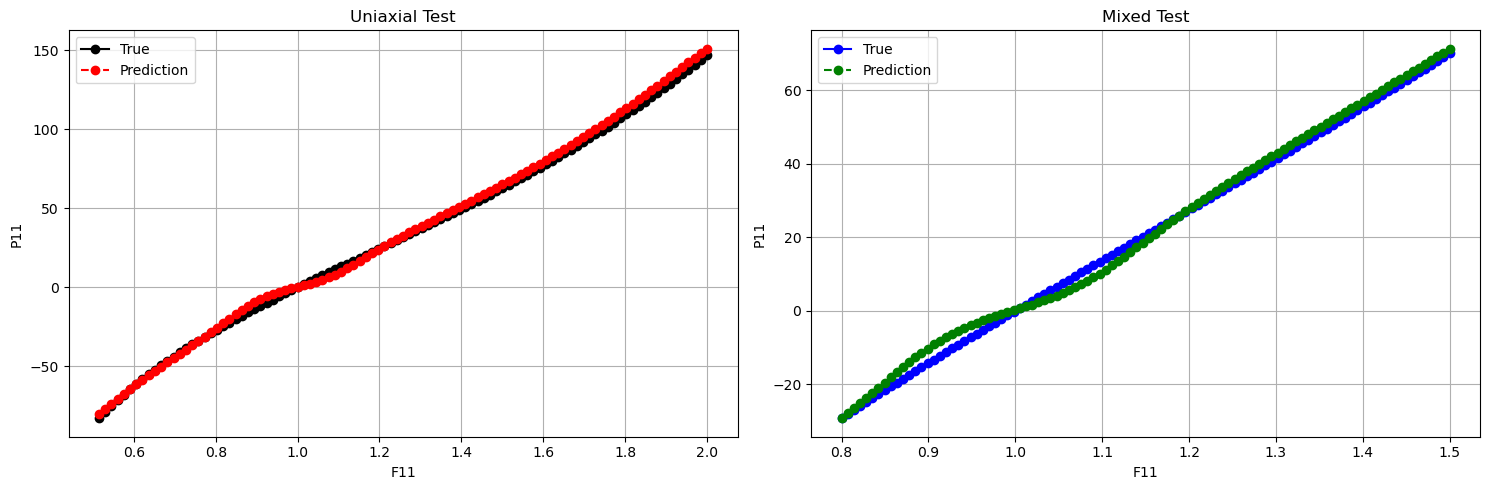

In [107]:
import matplotlib.pyplot as plt


def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0, 0]


    # 创建一个包含三个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test")
    ax2.legend()
    ax2.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)


In [108]:
W_uniaxial_pred, P_uniaxial_pred = predict(model, F_uniaxial)

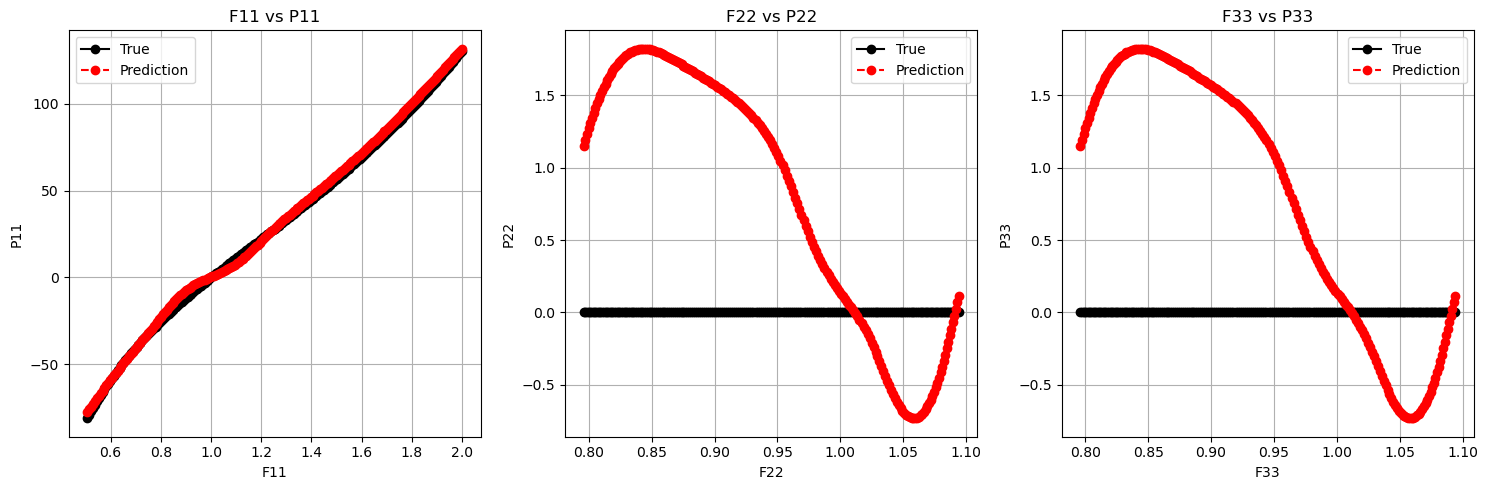

In [109]:
def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    # 提取 F 和 P 的不同分量
    F11 = F_uniaxial[:, 0, 0]  # 第一列
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] # 第三列

    P11 = P_uniaxial[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_uniaxial[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_uniaxial[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_uniaxial_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_uniaxial_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_uniaxial_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)
